## 1.Problem Statement and Background:

Silicon valley is the global centre for tech innovation and a home to many major software and internet companies. Office areas provide a huge opportunity for food trucks, especially during brunch hours.
We'll go thorugh the major cities included in silicon valley and try to decide which ones are suitable to open a sandwich cart considering serveral factors like cost,maintenance, audience availability etc.

### 1.1 Target audience:
- Anyone interested in cooking and wanting to see how a food cart would behave in a place like silicon valley before opening a full blown restaurant

- Any invester wanting to see if a particular food truck has the capability to grow into a full blown business/probability of success upon proper investment

- Any budding data scientist wanting to better understand using data to solve real life problems

## 2.Data preparation:

### 2.1 Scraping the list of cities from wikipedia
- [Wikipedia link](https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_the_San_Francisco_Bay_Area) contains information like population, area etc. about all cities and towns included in the San Fransico bay area (also known as Silicon Valley). We'll parse this page to fetch the data table.

In [1]:
import requests
import pandas as pd
import numpy as np 
from bs4 import BeautifulSoup

try:
    url = 'https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_the_San_Francisco_Bay_Area'
    result = requests.get(url)
    soup = BeautifulSoup(result.text)
    matches = soup.select('table')
    match = matches[1]
    df = pd.read_html(str(match))[0]
    print(df.head())
except Exception as e:
    print(e)
    

              Name  Type        County Population (2010)[8][9] Land area[8]  \
              Name  Type        County Population (2010)[8][9]        sq mi   
0          Alameda  City       Alameda                   73812        10.61   
1           Albany  City       Alameda                   18539         1.79   
2  American Canyon  City          Napa                   19454         4.84   
3          Antioch  City  Contra Costa                  102372        28.35   
4         Atherton  Town     San Mateo                    6914         5.02   

            Incorporated[7]  
    km2     Incorporated[7]  
0  27.5      April 19, 1854  
1   4.6  September 22, 1908  
2  12.5     January 1, 1992  
3  73.4    February 6, 1872  
4  13.0  September 12, 1923  


Here, we have a hierarchical index, which we can convert into a flat index for convinience. We don't really need the *Incorporated* column. Also, keeping only the *Land area km2* will do.

In [2]:
import re
#convert to flat index
cols_list = [' '.join(col).strip() if col[1]!=col[0] else col[0] for col in df.columns.values]
#remove reference numbers
cols_list = [re.sub(r'\[[0-9]\]','',col)  for col in cols_list] 
#re-assign columns
df.columns = cols_list
df.head()

,Name,Type,County,Population (2010),Land area sq mi,Land area km2,Incorporated
0,Alameda,City,Alameda,73812,10.61,27.5,"April 19, 1854"
1,Albany,City,Alameda,18539,1.79,4.6,"September 22, 1908"
2,American Canyon,City,Napa,19454,4.84,12.5,"January 1, 1992"
3,Antioch,City,Contra Costa,102372,28.35,73.4,"February 6, 1872"
4,Atherton,Town,San Mateo,6914,5.02,13.0,"September 12, 1923"


In [3]:
#Drop unnecessary columns
df.drop(['Incorporated','Land area sq mi'],axis=1,inplace=True)

In [4]:
#Sort according to population
df.sort_values(by='Population (2010)',ascending=False,inplace=True)
df.reset_index(drop=True,inplace=True)
df.head()

,Name,Type,County,Population (2010),Land area km2
0,San Jose,City,Santa Clara,945942,457.2
1,San Francisco,City and county,San Francisco,805235,121.4
2,Oakland,City,Alameda,390724,144.5
3,Fremont,City,Alameda,214089,200.6
4,Santa Rosa,City,Sonoma,177586,107.5


We are concerned only about the highly populated cities, so we'll refine our data to keep only the top 10 most populous cities.

In [5]:
df = df[df['Type'] == 'City'].loc[0:10,:]
df.reset_index(drop=True,inplace=True)
df.head(15)

,Name,Type,County,Population (2010),Land area km2
0,San Jose,City,Santa Clara,945942,457.2
1,Oakland,City,Alameda,390724,144.5
2,Fremont,City,Alameda,214089,200.6
3,Santa Rosa,City,Sonoma,177586,107.5
4,Hayward,City,Alameda,144186,117.4
5,Sunnyvale,City,Santa Clara,140081,57.0
6,Concord,City,Contra Costa,122067,79.1
7,Santa Clara,City,Santa Clara,116468,47.7
8,Vallejo,City,Solano,115942,79.4
9,Berkeley,City,Alameda,112580,27.1


### 2.2 Getting coordinates of major cities using Geopy

In [6]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='Silicon_Valley_explorer',timeout=10)
def city_coordinates(city_name):
    lat = geolocator.geocode(city_name).latitude
    lng = geolocator.geocode(city_name).longitude
    return lat,lng
df['Latitude'],df['Longitude'] = zip(*df['Name'].apply(city_coordinates))
df.head(15)

,Name,Type,County,Population (2010),Land area km2,Latitude,Longitude
0,San Jose,City,Santa Clara,945942,457.2,37.336191,-121.890583
1,Oakland,City,Alameda,390724,144.5,37.804456,-122.271356
2,Fremont,City,Alameda,214089,200.6,37.548270,-121.988572
3,Santa Rosa,City,Sonoma,177586,107.5,14.150152,-90.350882
4,Hayward,City,Alameda,144186,117.4,37.668821,-122.080796
5,Sunnyvale,City,Santa Clara,140081,57.0,37.368830,-122.036350
6,Concord,City,Contra Costa,122067,79.1,43.207178,-71.537476
7,Santa Clara,City,Santa Clara,116468,47.7,37.233325,-121.684635
8,Vallejo,City,Solano,115942,79.4,38.104086,-122.256637
9,Berkeley,City,Alameda,112580,27.1,37.870839,-122.272864


As we can see above, 2 of the cities have improper coordinates: **Santa Rosa** and **Concord**, because there are other cities in the world with the same name.

In [7]:
#Actual cities referred to:
geolocator.reverse(df.loc[3,'Latitude'],df.loc[3,'Longitude'])
geolocator.reverse(df.loc[6,'Latitude'],df.loc[6,'Longitude'])

Location(Chemin de Juillan, Azereix, Tarbes, Hautes-Pyrénées, Occitanie, France métropolitaine, 65380, France, (43.2099948, -0.003222, 0.0))

A simple google search reveals the actual coordinates, which we'll substitute.

In [8]:
df.loc[3,'Latitude'],df.loc[3,'Longitude'] = 38.4404, -122.7141
df.loc[6,'Latitude'],df.loc[6,'Longitude'] = 37.9780, -122.0311

In [9]:
df.head(15)

,Name,Type,County,Population (2010),Land area km2,Latitude,Longitude
0,San Jose,City,Santa Clara,945942,457.2,37.336191,-121.890583
1,Oakland,City,Alameda,390724,144.5,37.804456,-122.271356
2,Fremont,City,Alameda,214089,200.6,37.548270,-121.988572
3,Santa Rosa,City,Sonoma,177586,107.5,38.440400,-122.714100
4,Hayward,City,Alameda,144186,117.4,37.668821,-122.080796
5,Sunnyvale,City,Santa Clara,140081,57.0,37.368830,-122.036350
6,Concord,City,Contra Costa,122067,79.1,37.978000,-122.031100
7,Santa Clara,City,Santa Clara,116468,47.7,37.233325,-121.684635
8,Vallejo,City,Solano,115942,79.4,38.104086,-122.256637
9,Berkeley,City,Alameda,112580,27.1,37.870839,-122.272864


### 2.3 Getting major sandwich ingredient prices per city
- We are going to scrap www.numbeo.com using selenium for food prices of the basic ingredients of a healthy sandwich, namely: Bread, Onion, Eggs, Cheese, Tomato, Potato, and then try to estimate the cost of making sandwiches out of one loaf of bread.

In [10]:
!pip install selenium
!pip install webdriver-manager

In [11]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
browser = webdriver.Chrome(ChromeDriverManager().install())

Trying to download new driver from http://chromedriver.storage.googleapis.com/80.0.3987.106/chromedriver_win32.zip
Unpack archive C:\Users\1STAR\.wdm\drivers\chromedriver\80.0.3987.106\win32\chromedriver.zip


In [12]:
browser.get('https://www.numbeo.com/food-prices/country_result.jsp?country=United+States')

In [13]:
#Check the values in the cities drop down
elem = browser.find_element_by_id('city')
cities_drop_down = elem.find_elements_by_tag_name("option")
cities_list = [x.get_attribute("value") for x in cities_drop_down]
print(cities_list[0:5])

['', 'Aberdeen, SD', 'Abilene, TX', 'Abingdon, MD', 'Acton, MA']


We see that each option in the city drop down is just the name of city in our dataframe, appended with state code, in our case, *CA*. We'll one by one select each city under consideration and scrap the prices of basic ingredients of a sandwich to calculate the approximate cumulative investment to make sandwiches out of one loaf of bread. This analysis does exclude certain other factors such as price of sauces,ease of availability of these ingredients,type of labour available etc. for simplicity.

In [14]:
ingredients = ['Bread','Onion','Eggs', 'Cheese', 'Tomato', 'Potato']
for ind,city_name in enumerate(df['Name']):
    price = {}
    total_price_per_loaf = 0
    elem = browser.find_element_by_id('city')
    city_option_name = '{}, CA'.format(city_name)
    elem.send_keys(city_option_name)
    browser.implicitly_wait(5)
    ##fetch the prices
    elem = browser.find_element_by_xpath('//html/body/div/table/tbody')
    rows = elem.find_elements_by_tag_name('tr')
    for row in rows:
        price_info = row.find_elements_by_tag_name('td')
        price[price_info[0].text] = price_info[1].text.replace('$','').strip()
    
    for ingred in price:
        candidates = ingred.split(' ')
        if len([x for x in ingredients for y in candidates if x==y])>0:
            total_price_per_loaf += float(price[ingred])
    
    df.loc[ind,'Cost_per_loaf'] = total_price_per_loaf
    #go back to select another city
    browser.back()
    browser.implicitly_wait(10)

df.head()

,Name,Type,County,Population (2010),Land area km2,Latitude,Longitude,Cost_per_loaf
0,San Jose,City,Santa Clara,945942,457.2,37.336191,-121.890583,4.26
1,Oakland,City,Alameda,390724,144.5,37.804456,-122.271356,6.36
2,Fremont,City,Alameda,214089,200.6,37.548270,-121.988572,4.99
3,Santa Rosa,City,Sonoma,177586,107.5,38.440400,-122.714100,5.69
4,Hayward,City,Alameda,144186,117.4,37.668821,-122.080796,4.45


In [15]:
df.head(15)

,Name,Type,County,Population (2010),Land area km2,Latitude,Longitude,Cost_per_loaf
0,San Jose,City,Santa Clara,945942,457.2,37.336191,-121.890583,4.26
1,Oakland,City,Alameda,390724,144.5,37.804456,-122.271356,6.36
2,Fremont,City,Alameda,214089,200.6,37.548270,-121.988572,4.99
3,Santa Rosa,City,Sonoma,177586,107.5,38.440400,-122.714100,5.69
4,Hayward,City,Alameda,144186,117.4,37.668821,-122.080796,4.45
5,Sunnyvale,City,Santa Clara,140081,57.0,37.368830,-122.036350,4.78
6,Concord,City,Contra Costa,122067,79.1,37.978000,-122.031100,4.87
7,Santa Clara,City,Santa Clara,116468,47.7,37.233325,-121.684635,6.16
8,Vallejo,City,Solano,115942,79.4,38.104086,-122.256637,5.60
9,Berkeley,City,Alameda,112580,27.1,37.870839,-122.272864,5.89


In [16]:
browser.quit()

### 2.4 Getting venues nearby using Foursquare:
- We'll use foursquare API to fetch the venue data within 5km of the city centre of each city.
- This venue data will be used later to:
    - plot eateries all over silicon valley
    - cluster different cities in silicon valley based on density of certain venue categories
- We'll use this data to evaluate:
    - Which cities have less eateries, hence less competition for our up and coming cart
    - Which cities have more parks and offices/institutes, because that's going to be the major audience

In [17]:
import json
with open('secrets.json') as f:
    data = json.load(f)

CLIENT_ID = data['foursquare']['client_id']
CLIENT_SECRET = data['foursquare']['client_secret']
VERSION = data['foursquare']['version']

Foursquare **explore** endpoint provides categories for nearby venues to a location. But there are too many categories and it might lead to overfitting our model eventually. The **categories** endpoint provides an exhaustive hierarchy of all the categories assigned by foursquare api to any venue. We can use this list to associate each venue with the top-level category associated with its own category name. This will help us reduce the total number of different category names.

In [18]:
#1. EXPLORING NEIGHBORHOODS' VENUES
from pandas.io.json import json_normalize
categories_loaded = False
categories_hierarchy = {}
top_level_categories = {}


def getAllCategories(force_load=False):
    global categories_loaded
    global categories_hierarchy
    if(force_load or not categories_loaded):
        url='https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION
        )
        categories_hierarchy = requests.get(url).json()['response']['categories']
        categories_loaded=True
    return categories_hierarchy

def assignCategory(category_name,json_tree):
    global top_level_categories
    top_level_categories[json_tree['name']] = category_name
    for category in json_tree['categories']:
        assignCategory(category_name,category)
    
def assignTopLevelCategory():
    global top_level_categories
    global categories_hierarchy
    getAllCategories()
    for category in categories_hierarchy:
        top_level = category['name']
        top_level_categories[top_level] = top_level
        for child_category in category['categories']:
            assignCategory(top_level,child_category)
        
        
def getNearbyVenues(nbrs,lats,lngs,radius=5000):
    global top_level_categories
    venues = []
    for nbr,lat,lng in zip(nbrs,lats,lngs):
        url='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            100
        )

        items = requests.get(url).json()['response']['groups'][0]['items']
        venues += [[nbr,lat,lng,item['venue']['name'],item['venue']['location']['lat'],
                    item['venue']['location']['lng'],
                   top_level_categories[item['venue']['categories'][0]['name']]] for item in items]
        
    nbr_df = pd.DataFrame(venues)
    nbr_df.columns = ['Nbr','Nbr_lat','Nbr_lng','Venue','Venue_lat','Venue_lng','Venue Category']
    return nbr_df
    
assignTopLevelCategory()
venues_df = getNearbyVenues(df.loc[:,'Name'],df.loc[:,'Latitude'],df.loc[:,'Longitude'])
venues_df.head()

,Nbr,Nbr_lat,Nbr_lng,Venue,Venue_lat,Venue_lng,Venue Category
0,San Jose,37.336191,-121.890583,Back A Yard Caribbean American Grill,37.336683,-121.892749,Food
1,San Jose,37.336191,-121.890583,Original Gravity Public House,37.335052,-121.889747,Nightlife Spot
2,San Jose,37.336191,-121.890583,San Pedro Square Market,37.336480,-121.894403,Food
3,San Jose,37.336191,-121.890583,San Pedro Square,37.335179,-121.893044,Outdoors & Recreation
4,San Jose,37.336191,-121.890583,Ike's Sandwiches,37.336852,-121.889436,Food


In [19]:
#Let's see what kinds of categories are there
venues_df['Venue Category'].unique()

array(['Food', 'Nightlife Spot', 'Outdoors & Recreation',
       'Shop & Service', 'Arts & Entertainment', 'Travel & Transport',
       'College & University', 'Professional & Other Places'],
      dtype=object)

## 3.Data processing and visualization:

In [20]:
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

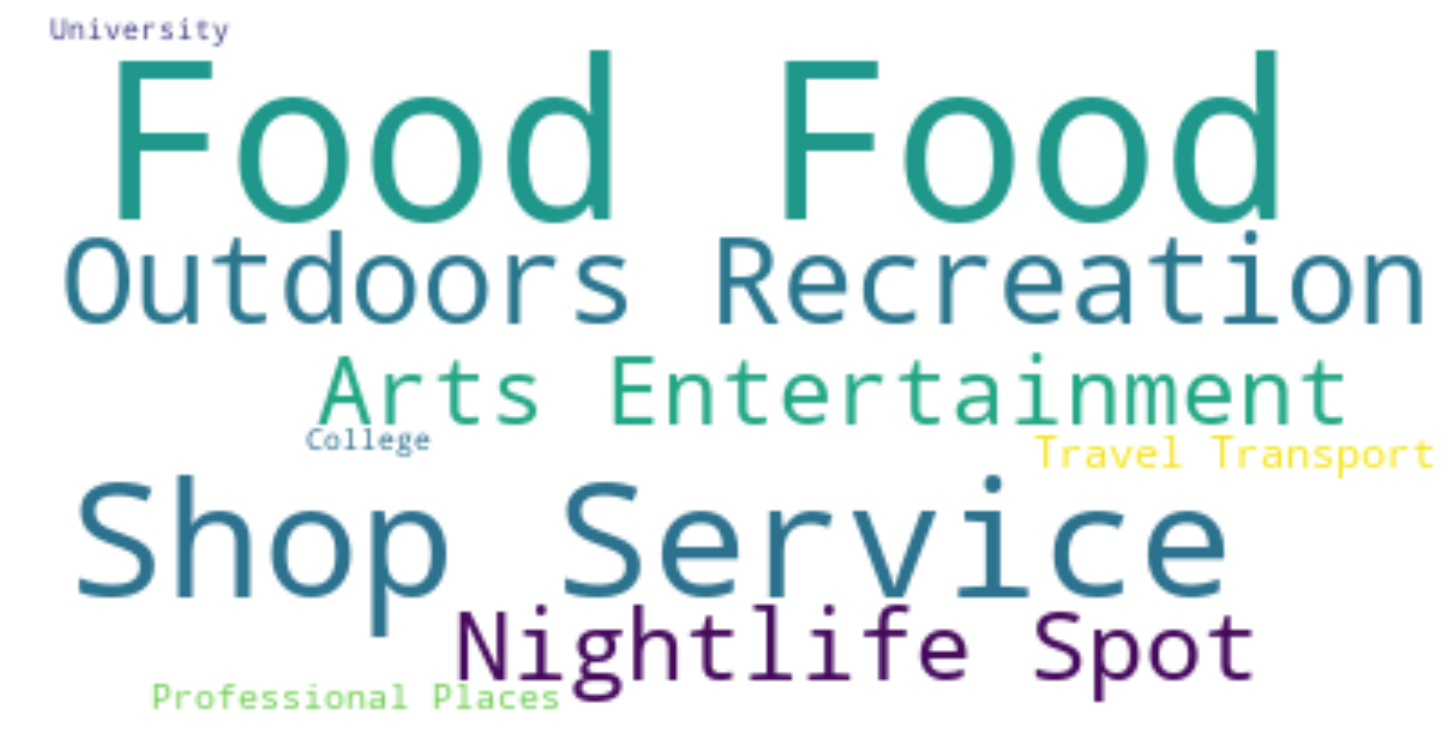

In [21]:
import matplotlib.pyplot as plt
text = venues_df['Venue Category'].values
wordcloud = WordCloud(
                background_color='white',
                stopwords=STOPWORDS).generate(' '.join(text))
fig = plt.figure(figsize = (20,20))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

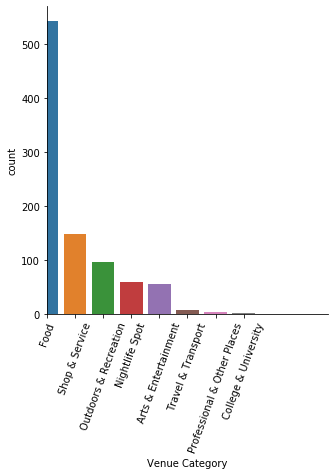

In [22]:
import seaborn as sns

sns.catplot(x='Venue Category',kind='count',data=venues_df,order = venues_df['Venue Category'].value_counts().index)
plt.xlim(0,10)
plt.xticks(rotation=70)
plt.show()

In [23]:
onehot_df = pd.get_dummies(venues_df[['Venue Category']],prefix='',prefix_sep='')

In [24]:
onehot_df['City'] = venues_df['Nbr']
mean_vectors_df = onehot_df.groupby('City').mean().reset_index()
mean_vectors_df.head()

,City,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Berkeley,0.09,0.01,0.50,0.06,0.11,0.00,0.23,0.00
1,Concord,0.02,0.00,0.70,0.03,0.06,0.01,0.18,0.00
2,Fremont,0.03,0.00,0.62,0.01,0.11,0.01,0.22,0.00
3,Hayward,0.03,0.00,0.63,0.04,0.09,0.01,0.19,0.01
4,Oakland,0.07,0.00,0.59,0.20,0.05,0.00,0.09,0.00


In [25]:
mean_vectors_df.drop('City',1,inplace=True)

In [26]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=5,random_state=0).fit(mean_vectors_df)
print(model.labels_)

[2 0 0 0 3 3 1 2 4 0]


In [27]:
mean_vectors_df.insert(0,'Cluster label',model.labels_)
labelled_df = pd.concat([df, mean_vectors_df], axis=1)
labelled_df.head()

,Name,Type,County,Population (2010),Land area km2,Latitude,Longitude,Cost_per_loaf,Cluster label,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,San Jose,City,Santa Clara,945942,457.2,37.336191,-121.890583,4.26,2,0.09,0.01,0.50,0.06,0.11,0.00,0.23,0.00
1,Oakland,City,Alameda,390724,144.5,37.804456,-122.271356,6.36,0,0.02,0.00,0.70,0.03,0.06,0.01,0.18,0.00
2,Fremont,City,Alameda,214089,200.6,37.548270,-121.988572,4.99,0,0.03,0.00,0.62,0.01,0.11,0.01,0.22,0.00
3,Santa Rosa,City,Sonoma,177586,107.5,38.440400,-122.714100,5.69,0,0.03,0.00,0.63,0.04,0.09,0.01,0.19,0.01
4,Hayward,City,Alameda,144186,117.4,37.668821,-122.080796,4.45,3,0.07,0.00,0.59,0.20,0.05,0.00,0.09,0.00


In [41]:
#Map centered in California
import time
import os
import folium

mean_lat=labelled_df['Latitude'].mean() 
mean_lng=labelled_df['Longitude'].mean()
print(mean_lat,mean_lng)
map_cities = folium.Map(location=[mean_lat,mean_lng],zoom_start=8)

markers_colors = [
    'red',
    'blue',
    'gray',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'green',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'purple',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black'
]

for latitude, longitude, city, cluster_label in zip(labelled_df['Latitude'],labelled_df['Longitude'],labelled_df['Name'],labelled_df['Cluster label']):
    label=folium.Popup(city,parse_html=True)
    folium.CircleMarker(
        [latitude,longitude],
        popup=label,
        radius=5,
        color=markers_colors[int(cluster_label)],
        fill_color=markers_colors[int(cluster_label)],
        fill=True,
        fill_opacity=0.7
    ).add_to(map_cities)

map_cities.save('map.html')
browser = webdriver.Chrome(ChromeDriverManager().install())
browser.set_window_size(4000,3000)
browser.get('file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile='map.html'))
time.sleep(100)
browser.save_screenshot('map.png')
browser.quit()

37.73532175 -122.1226993

Looking for [chromedriver 80.0.3987.106 win32] driver in cache 
File found in cache by path [C:\Users\1STAR\.wdm\drivers\chromedriver\80.0.3987.106\win32\chromedriver.exe]


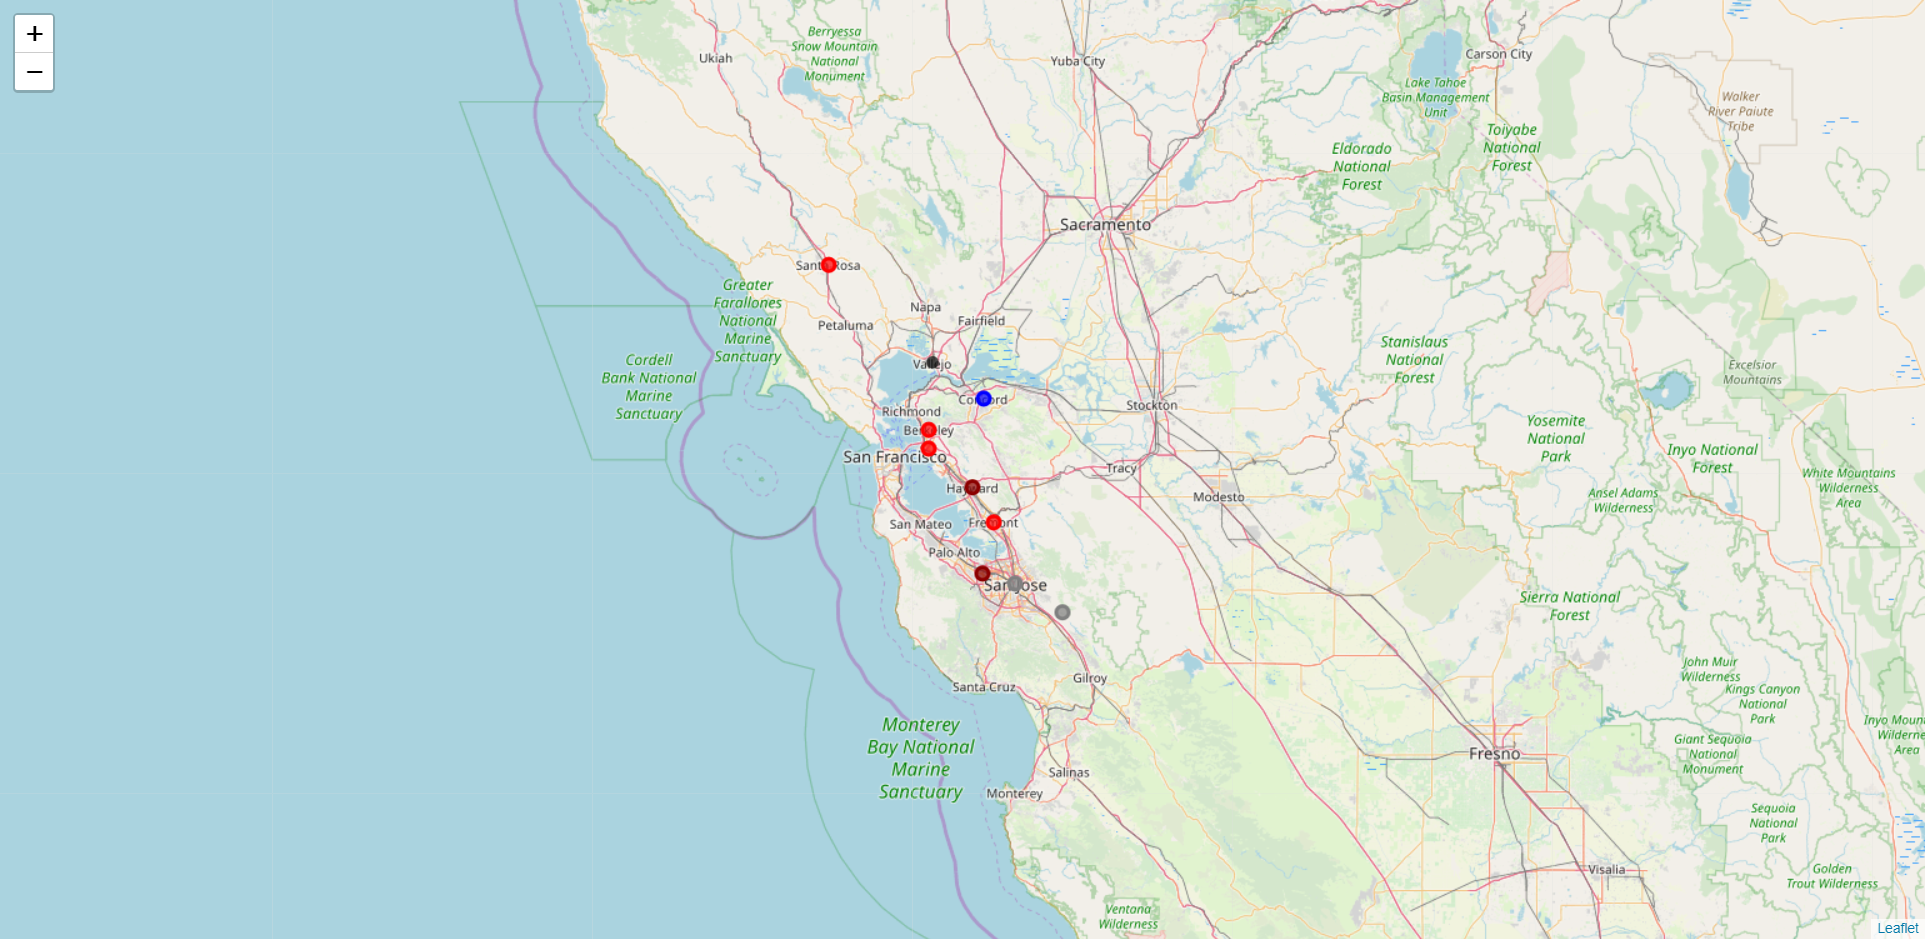

In [49]:
labelled_df.loc[labelled_df['Cluster label']==0,labelled_df.columns[[0,3,7]+list(range(9,labelled_df.shape[1]))]]

,Name,Population (2010),Cost_per_loaf,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
1,Oakland,390724,6.36,0.02,0.0,0.70,0.03,0.06,0.01,0.18,0.00
2,Fremont,214089,4.99,0.03,0.0,0.62,0.01,0.11,0.01,0.22,0.00
3,Santa Rosa,177586,5.69,0.03,0.0,0.63,0.04,0.09,0.01,0.19,0.01
9,Berkeley,112580,5.89,0.09,0.0,0.64,0.04,0.10,0.00,0.13,0.00


In this cluster, we see food is the major category, with almost 65% of the venues being in it, then are the shopping venues and then there are few recreational and entertainment venues.

In [50]:
labelled_df.loc[labelled_df['Cluster label']==1,labelled_df.columns[[0,3,7]+list(range(9,labelled_df.shape[1]))]]

,Name,Population (2010),Cost_per_loaf,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
6,Concord,122067,4.87,0.0,0.0,0.3,0.0,0.7,0.0,0.0,0.0


Above, we can see Concord has lots of opportunities in form of recreational places to park our cart at. Even though food places are not the most common here, they are still present, and in significant amount, hence leading to significant competition.

In [51]:
labelled_df.loc[labelled_df['Cluster label']==2,labelled_df.columns[[0,3,7]+list(range(9,labelled_df.shape[1]))]]

,Name,Population (2010),Cost_per_loaf,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,San Jose,945942,4.26,0.09,0.01,0.50,0.06,0.11,0.00,0.23,0.00
7,Santa Clara,116468,6.16,0.05,0.00,0.56,0.06,0.08,0.01,0.22,0.02


In this cluster, we see food is the major category, with almost 50% of the venues being in it, then are the shopping venues and then there are few recreational, entertainment as well as nightlife spots present as well.

In [52]:
labelled_df.loc[labelled_df['Cluster label']==3,labelled_df.columns[[0,3,7]+list(range(9,labelled_df.shape[1]))]]

,Name,Population (2010),Cost_per_loaf,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
4,Hayward,144186,4.45,0.07,0.00,0.59,0.20,0.05,0.0,0.09,0.00
5,Sunnyvale,140081,4.78,0.14,0.01,0.57,0.13,0.07,0.0,0.07,0.01


In this cluster, we see food is the major category, with almost 60% of the venues being in it, then there are nightlife spots, and then there are a few art,recreational and shopping venues.

In [53]:
labelled_df.loc[labelled_df['Cluster label']==4,labelled_df.columns[[0,3,7]+list(range(9,labelled_df.shape[1]))]]

,Name,Population (2010),Cost_per_loaf,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
8,Vallejo,115942,5.6,0.03,0.0,0.58,0.01,0.22,0.0,0.14,0.02


In this cluster, we see food is the major category, with almost 60% of the venues being in it, then there are outdoor spots, and then there are some shopping venues.

## 4. Evaluation

### 4.1 Choosing city based on clusters:

We see that **Concord** has minimum **food joints**, followed by **San Jose** and **Santa Clara**. **Shopping venues**, which might help out with ingredients and cart maintenance, are most in **San Jose** and **Santa Clara** followed by **Vallejo**. **Recreational venues**, which provide a parking spot and abundant audience for the cart, are most in **Vallejo**, followed by many other cities with almost the same proportion of such venues.

### 4.2 Choosing city based on population:

In [55]:
labelled_df

,Name,Type,County,Population (2010),Land area km2,Latitude,Longitude,Cost_per_loaf,Cluster label,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,San Jose,City,Santa Clara,945942,457.2,37.336191,-121.890583,4.26,2,0.09,0.01,0.50,0.06,0.11,0.00,0.23,0.00
1,Oakland,City,Alameda,390724,144.5,37.804456,-122.271356,6.36,0,0.02,0.00,0.70,0.03,0.06,0.01,0.18,0.00
2,Fremont,City,Alameda,214089,200.6,37.548270,-121.988572,4.99,0,0.03,0.00,0.62,0.01,0.11,0.01,0.22,0.00
3,Santa Rosa,City,Sonoma,177586,107.5,38.440400,-122.714100,5.69,0,0.03,0.00,0.63,0.04,0.09,0.01,0.19,0.01
4,Hayward,City,Alameda,144186,117.4,37.668821,-122.080796,4.45,3,0.07,0.00,0.59,0.20,0.05,0.00,0.09,0.00
5,Sunnyvale,City,Santa Clara,140081,57.0,37.368830,-122.036350,4.78,3,0.14,0.01,0.57,0.13,0.07,0.00,0.07,0.01
6,Concord,City,Contra Costa,122067,79.1,37.978000,-122.031100,4.87,1,0.00,0.00,0.30,0.00,0.70,0.00,0.00,0.00
7,Santa Clara,City,Santa Clara,116468,47.7,37.233325,-121.684635,6.16,2,0.05,0.00,0.56,0.06,0.08,0.01,0.22,0.02
8,Vallejo,City,Solano,115942,79.4,38.104086,-122.256637,5.60,4,0.03,0.00,0.58,0.01,0.22,0.00,0.14,0.02
9,Berkeley,City,Alameda,112580,27.1,37.870839,-122.272864,5.89,0,0.09,0.00,0.64,0.04,0.10,0.00,0.13,0.00


**San Jose** is most populated, hence possibly provides more customers, then followed by **Oakland**,**Fremont** and **Santa Rose**. Rest of the other cities have almost comparable populations.

### 4.3 Choosing city based on cost of sandwiches in one loaf of bread:

In [59]:
labelled_df.sort_values(by='Cost_per_loaf').reset_index(drop=True)

,Name,Type,County,Population (2010),Land area km2,Latitude,Longitude,Cost_per_loaf,Cluster label,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,San Jose,City,Santa Clara,945942,457.2,37.336191,-121.890583,4.26,2,0.09,0.01,0.50,0.06,0.11,0.00,0.23,0.00
1,Hayward,City,Alameda,144186,117.4,37.668821,-122.080796,4.45,3,0.07,0.00,0.59,0.20,0.05,0.00,0.09,0.00
2,Sunnyvale,City,Santa Clara,140081,57.0,37.368830,-122.036350,4.78,3,0.14,0.01,0.57,0.13,0.07,0.00,0.07,0.01
3,Concord,City,Contra Costa,122067,79.1,37.978000,-122.031100,4.87,1,0.00,0.00,0.30,0.00,0.70,0.00,0.00,0.00
4,Fremont,City,Alameda,214089,200.6,37.548270,-121.988572,4.99,0,0.03,0.00,0.62,0.01,0.11,0.01,0.22,0.00
5,Vallejo,City,Solano,115942,79.4,38.104086,-122.256637,5.60,4,0.03,0.00,0.58,0.01,0.22,0.00,0.14,0.02
6,Santa Rosa,City,Sonoma,177586,107.5,38.440400,-122.714100,5.69,0,0.03,0.00,0.63,0.04,0.09,0.01,0.19,0.01
7,Berkeley,City,Alameda,112580,27.1,37.870839,-122.272864,5.89,0,0.09,0.00,0.64,0.04,0.10,0.00,0.13,0.00
8,Santa Clara,City,Santa Clara,116468,47.7,37.233325,-121.684635,6.16,2,0.05,0.00,0.56,0.06,0.08,0.01,0.22,0.02
9,Oakland,City,Alameda,390724,144.5,37.804456,-122.271356,6.36,0,0.02,0.00,0.70,0.03,0.06,0.01,0.18,0.00


Having the cart at **San Jose** will cost us the cheapest to turn one loaf of bread into sandwiches. **Concord** falls on the cheaper side comparitively, while **Santa Rosa** kind of costs much more. **Oakland** seems to be the costliest.

## 5. Conclusion and further research:

### 5.1 Conclusion:

**San Jose** seems to be the best place to open a sandwich cart considerng the high population, low existing food joints density and low cost per sandwich, followed by **Fremont** which even though does have high food joint density, has low enough per sandwich cost and high enough population, and **Concord**, which has the least density of food joints, cheap sandwiches and good enough population for possible customers.

### 5.2 Further research:

There are still certain considerations which can be added upon to improve this work:
- Considering population distribution: how many people are teens are hence eat more fast food, how many are adults and are less likely to eat junk.
- Including density of gas stations, city economical situation
- Considering road permit rules, number of hours food trucks are allowed to park per day for a particular city, condition of roads and whether they facilitate transport
- Refining the cost for one sandwich to be more precise, including all the minor ingredients as well
- Considering multiple places within each city. That would require researching a lot of data, which I don't have the time/resources to complete right now.
